### LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from pandas_profiling import ProfileReport
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from pyvi import ViPosTagger, ViTokenizer
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\marsen\AppData\Local\Temp\ipykernel_20796\1494690340.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
df1 = pd.read_csv("comments_new.csv", encoding="utf-8")

In [3]:
df1.head()

,product_id,comment_id,title,thank_count,customer_id,rating,comment
0,78895866,14155875,Cực kì hài lòng,0,6685717,5,NaN
1,78895866,13062056,Cực kì hài lòng,0,1547272,5,NaN
2,78895866,8693221,Cực kì hài lòng,0,21013331,5,"tôi rất hài lòng với sản phẩm này, nói chung ok"
3,78895866,12785832,Cực kì hài lòng,0,1743813,5,NaN
4,78895866,12714519,Cực kì hài lòng,0,13793638,5,NaN


In [4]:
profile = ProfileReport(df1)
profile.get_description()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

{'analysis': {'title': 'Pandas Profiling Report',
  'date_start': datetime.datetime(2023, 4, 5, 6, 26, 27, 149769),
  'date_end': datetime.datetime(2023, 4, 5, 6, 26, 49, 146072),
  'duration': datetime.timedelta(seconds=21, microseconds=996303)},
 'table': {'n': 447651,
  'n_var': 7,
  'memory_size': 25068584,
  'record_size': 56.00028593703577,
  'n_cells_missing': 184213,
  'n_vars_with_missing': 2,
  'n_vars_all_missing': 0,
  'p_cells_missing': 0.05878718657423497,
  'types': {'Numeric': 4, 'Categorical': 3},
  'n_duplicates': 87384,
  'p_duplicates': 0.1952056401080306},
 'variables': {'product_id': {'n_distinct': 9184,
   'p_distinct': 0.020515982316581444,
   'is_unique': False,
   'n_unique': 7,
   'p_unique': 1.5637181643735856e-05,
   'type': 'Numeric',
   'hashable': True,
   'value_counts_without_nan': 107363748    600
   116446788    400
   75403873     400
   95089986     400
   85186200     400
               ... 
   213845608      1
   49995900       1
   201697050    

In [5]:
df1['rating'].value_counts()

5    343052
4     57142
1     24031
3     15345
2      8081
Name: rating, dtype: int64

In [6]:
df1.shape

(447651, 7)

### Phân chia theo nhóm
Ta sẽ chia bộ dữ liệu theo thành từng nhóm (class), trong đó:
- 1-2: rating không thích
- 3: rating trung tính
- 4-5: rating thích

In [7]:
df_notlike = df1[df1['rating'] < 3 ]

In [8]:
df_neutral= df1[df1['rating'] == 3 ]

In [9]:
df_like = df1[df1['rating'] > 3 ]

### CHECK ISNULL

In [10]:
df2 = df1[["rating","comment"]].copy()

In [11]:
df2.isnull().sum()

rating          0
comment    184201
dtype: int64

In [12]:
df_isnull = df2[df2['comment'].isnull()]

In [13]:
df_isnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184201 entries, 0 to 447650
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   rating   184201 non-null  int64 
 1   comment  0 non-null       object
dtypes: int64(1), object(1)
memory usage: 4.2+ MB


In [14]:
df_count = df_isnull['rating'].value_counts()
df_result = pd.DataFrame(df_count)
df_result = df_result.reset_index()
df_result.columns = ['rating','value_counts']
print(df_result)

   rating  value_counts
0       5        157811
1       4         25343
2       3           853
3       1           139
4       2            55


### CHECK AND DROP DUPLICATED COMMENTS

In [15]:
df3 = df1[~df1['comment'].isnull()]

In [16]:
df3.duplicated().sum()

67325

In [17]:
df3.drop_duplicates(inplace=True)

In [18]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196125 entries, 2 to 447639
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   product_id   196125 non-null  int64 
 1   comment_id   196125 non-null  int64 
 2   title        196117 non-null  object
 3   thank_count  196125 non-null  int64 
 4   customer_id  196125 non-null  int64 
 5   rating       196125 non-null  int64 
 6   comment      196125 non-null  object
dtypes: int64(5), object(2)
memory usage: 12.0+ MB


In [19]:
for index, row in df3.sample(50).iterrows():
    print(row['comment'])

Hàng đẹp như mẫu
Sản phẩm đẹp, chắc chắn, còn có tua vít và 2 ốc đi kèm (1 cái dự phòng), giá cao hơn so với sản phẩm khác cùng loại nhưng nói chung đáng mua, sẽ mua thêm nếu cần.
Màu xài cực tốt, lên đẹp, đc tặng nhiều quà! Khuyến khích mọi người nên mua nhé! Đóng gói chắc chắn, cẩn thận
Hàng chuẩn, dùng rất ok.
Tản nhiệt tốt, quạt chạy êm
Hàng đúng loại cần mua. Chưa dùng thử nên chưa biết chât lượng mực thế nào.
ok sản phẩm rất tốt so với tầm giá chất âm tạm ổn,bass to. nói chung là hài lòng với sản phẩm tầm giá này
Có một hộp kcn thôi nhưng shop đóng hàng rất cẩn thận, nhận hàng về mà hộp vẫn thẳng nguyên ko móp méo. Chất lượng kcn cell fusion thì khỏi phải bàn rồi. Chất kem mỏng mịn hơi nâng tông xíu. Mình rất thích. Mua đợt sale vừa rồi được giá tốt nữa
Chuột sạc điện nên thỉnh thoảng lại phải sạc. DPI tạm ổn. Sử dụng khó chính xác hơn chuột thường và mấy con chuột đứng cùng loại
Tiki Ship hàng siêu nhanh. Hàng được gói rất cẩn thận. Máy màu xanh siêu ưng luôn tuy ra lâu rồi 

In [20]:
df3.shape

(196125, 7)

### KEEP RATING AND COMMENT DATA

In [21]:
df4 = df3[['rating','comment']]

In [22]:
conditions = [
    (df4['rating'] < 3),
    (df4['rating'] == 3),
    (df4['rating'] > 3)
]

values = ['negative', 'neutral', 'positive']

df4['class'] = np.select(conditions, values)
df4 = df4[['comment','class']]

In [23]:
df4.reset_index(drop=True, inplace=True)

In [24]:
df4.head()

,comment,class
0,"tôi rất hài lòng với sản phẩm này, nói chung ok",positive
1,ọ,positive
2,"Sản phẩm có chất lượng đúng như mô tả, đóng gó...",positive
3,"Sản phẩm có chất lượng đúng như mô tả, đóng gó...",positive
4,"Sản phẩm có chất lượng đúng như mô tả, đóng gó...",positive


In [25]:
df4.isnull().sum()

comment    0
class      0
dtype: int64

In [26]:
df4['class'].value_counts()

positive    162687
negative     22678
neutral      10760
Name: class, dtype: int64

### CLEAN TEXT

In [27]:
from processing import *

In [28]:
# Create a cluster
cluster = LocalCluster()
client = Client(cluster)
dask.config.set(scheduler='multiprocessing')

In [29]:
from processing import processing_text

Convert dask df to pd df

In [30]:
# Create a dask dataframe from the pandas dataframe
ddf = dd.from_pandas(df4, npartitions=16)
ddf = ddf.map_partitions(processing_text)
# Convert the dask dataframe to pandas dataframe
with ProgressBar():
    df = ddf.compute(num_workers=7)
del ddf

[########################################] | 100% Completed | 374.91 s


In [31]:
for index, row in df.sample(100).iterrows():
    print(row['processed_text'])

rất_tôi rất_hài lịch dã_ngoại khúc đời hát thư_giãn
bìa thiết kêz xinkkk màu ưng mắt sổ gáy còng
hàng shiper
sản_phẩm ổn tầm giá không_tận tâm
hàng hôm gắn đổi
mực màu uki bút nhẹ
không_đi
thơm khô thoáng rất_dễ bị_kích ứng
xài tuýp không_thấy tác_dụng
sản phâm tốt
không_vấn đề ráng sạch màu trắng dơ lắm


giấy đẹp bìa đẹp

hàng hàng rất_đúng hẹn xài tốt như_đánh giá
ổ_đĩa fullbox viết đóng gói kỹ đẹp chạy thử ổn bền đóng gói
đai chườm rất_tốt đeo bớt đau chân liền mùi thơm_thảo dược rất_dễ
sản_phẩm hàng
lắp tốt độ bền tốt không
tốt
hàng đóng_gói cẩn_thận sản_phẩm tốt
sản_phẩm hãng mô_tả
chân vệ
chất hơi_đặc bôi mùa đông hợp mùa hè

đóng gói tốt dịch thời gần_tháng mơi hàng
đầu thất_vọng fone sạc hư fone hàng giá rẻ quá_thất vọng
đóng_góp
hàng đóng_gói sản_phẩm hãng
hàng
sản_phẩm
dán

hàng chậm phí chất_lượng xứng_đáng shipper điện_báo trễ hàng sản_phẩm hãng giá tốt

sản_phẩm tương_đổi tốt bịt độ ồn thời cũng_chưa bị_biến dạng
gọn xài tốt nóng
đonga gói hàng trading yên_tâm
giá rẻ chất

In [32]:
df.reset_index(drop=True, inplace=True)

In [33]:
df_final = df[['processed_text','class']]

In [34]:
df_final.head()

,processed_text,class
0,rất_hài sản_phẩm,positive
1,,positive
2,sản_phẩm chất_lượng như_mô tả đóng_gói hàng rấ...,positive
3,sản_phẩm chất_lượng như_mô tả đóng_gói rất_đán...,positive
4,sản_phẩm chất_lượng như_mô tả đóng_gói rất_đán...,positive


In [35]:
df_final['processed_text'].loc[1]

''

In [36]:
df_final.to_csv('comment_new_final.csv')

### VISUALIZE USING WORDCLOUD

Negative

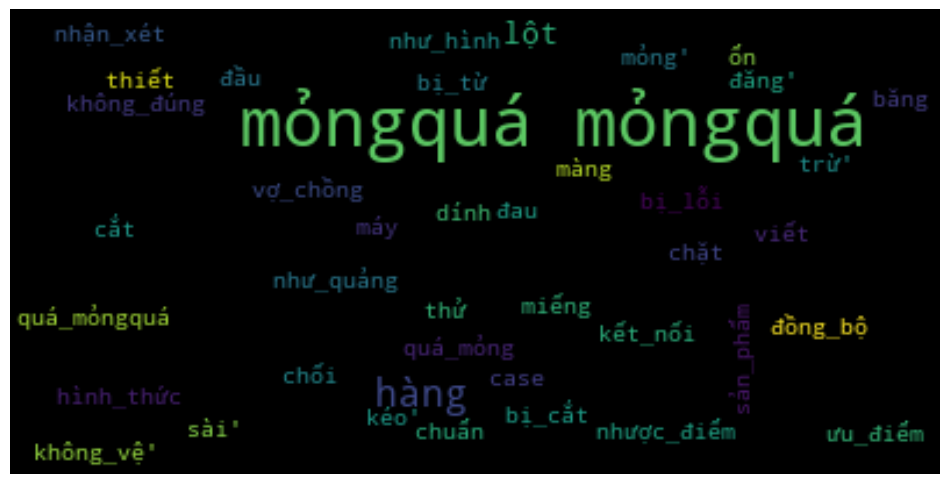

In [41]:
df_final_notlike = df_final[df_final['class'] == 'negative' ]
wc_notlike = WordCloud(
    background_color='black',
    max_words=500
)
wc_notlike.generate(str(df_final_notlike['processed_text'].values))
plt.figure(figsize=(12, 12))
plt.imshow(wc_notlike, interpolation='bilinear')
plt.axis('off')
plt.show()

Neutral

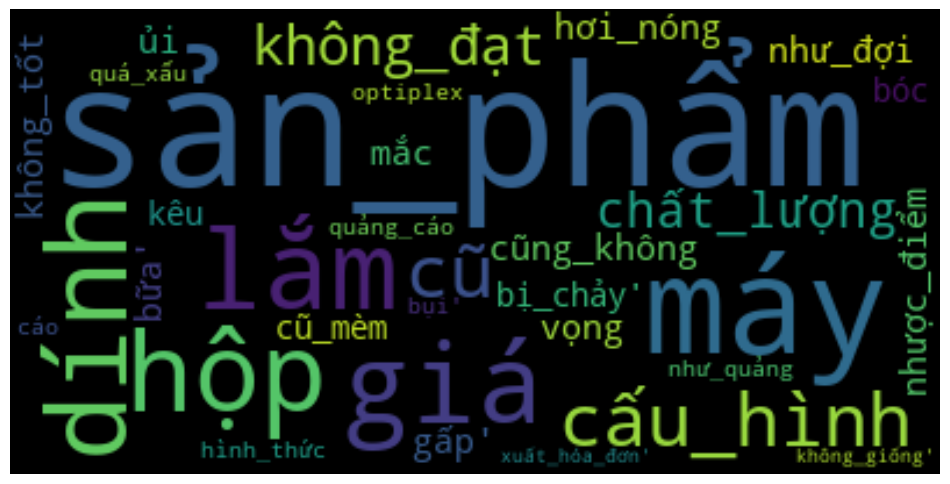

In [38]:
df_final_neutral = df_final[df_final['class'] == 'neutral' ]
wc_neutral = WordCloud(
    background_color='black',
    max_words=500
)
wc_neutral.generate(str(df_final_neutral['processed_text'].values))
plt.figure(figsize=(12, 12))
plt.imshow(wc_neutral, interpolation='bilinear')
plt.axis('off')
plt.show()

Positive

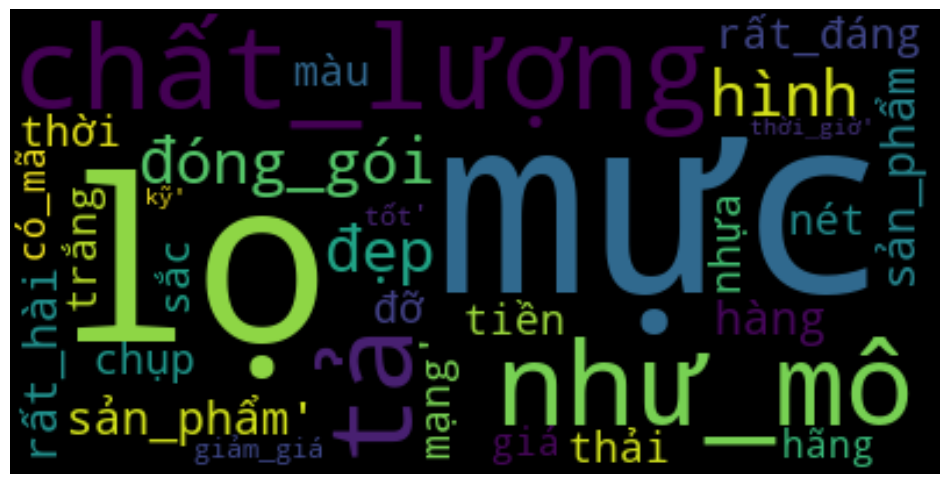

In [40]:
df_final_like = df_final[df_final['class'] == 'positive' ]
wc_like = WordCloud(
    background_color='black',
    max_words=500
)
wc_like.generate(str(df_final_like['processed_text'].values))
plt.figure(figsize=(12, 12))
plt.imshow(wc_like, interpolation='bilinear')
plt.axis('off')
plt.show()